## Selection models parameters

### Contents
* [Task description](#Task-description)
* [Model description](#Model-description)
* [The parameters studied](#The-parameters-studied)
* [Parameters value area](#Parameters-value-area)
* [Dataset](#Dataset-loading)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)

### Task description

Select bet parameters for Unet like model for first break pickigng task

### The parameters studied

Number of filters and kernel_size.

### Parameters value area

* _number of filters in decoreder/encoder block_ - $[8, 16, 32, 64], [16, 32, 64, 128]$

* _convolution kernel size_ - $4, 5, 7.$

In [1]:
import sys
import numpy as np

sys.path.append('../..')

from matplotlib import colors as mcolors
from seismicpro.batchflow import Pipeline, Dataset, B, V, F, C
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import SeismicBatch, FieldIndex, TraceIndex, seismic_plot, CustomIndex, show_research
from seismicpro.batchflow.research import Research, Option

from picking_batch import PickingBatch

### Dataset

Dataset is given by SEGY file with traces from Pal terrain as well as labels picking time for traces

In [2]:
path_raw = 'Pal_Flatiron_1k.sgy'
markup_path = 'Pal_Flatiron_1k_picking.csv'
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)

* Set the train and validatation data
* Set models config

In [3]:
train_subset = range(1, 5)
train_index = index.create_subset(index.indices[train_subset])
train_data = Dataset(TraceIndex((train_index)), PickingBatch)

In [4]:
test_index = index.create_subset(index.indices[5:7])
test_data = Dataset(TraceIndex((test_index)), PickingBatch)

In [5]:
inputs_config = {
    'raw1': {'shape': (1, 753)}, #753 PAL
    'mask': {'shape': (1, 753),
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'raw1',
    'optimizer': ('Adam', {'lr': 0.01}),
    'head/num_classes': 2, 
    'body/num_blocks': 4,
    'body/filters': C('filters'),
    'body/encoder': dict(layout='cna cna', kernel_sizee=C('kernel_size')),
    'body/decoder': dict(layout='cna cna', kernel_size=C('kernel_size')),
    'device': C('device')
}

Instances of train and test pipelines.

In [6]:
B_SIZE = 128
train_pipeline = (Pipeline()
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .drop_zero_traces(num_zero=700, src='raw')
                      .normalize(src='raw', dst='raw')
                      .new_mask(src='markup', dst='mask')
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', init_on_each_run=list)
                      .train_model('my_model', B('raw'), B('mask'),
                                   fetches='loss', save_to=V('loss'), mode='w')
                      .run(B_SIZE, n_epochs=None, drop_last=True, shuffle=True, lazy=True))

test_pipeline = (Pipeline()
                      .import_model('my_model', C('import_from'))
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .drop_zero_traces(num_zero=700, src='raw')
                      .normalize(src='raw', dst='raw')
                      .new_mask(src='markup', dst='mask')
                      .init_variable('picking', init_on_each_run=list())
                      .update_variable('picking', B('mask'), mode='a')
                      .add_components(components='unet_predictions')
                      .predict_model('my_model', B('raw'),
                                     fetches=['predictions_labels'],  save_to=[B('unet_predictions')], mode='a')
                      .mask_to_pick(src='unet_predictions', dst='unet_predictions')
                      .init_variable('predictions', init_on_each_run=list())
                      .update_variable('predictions', B('unet_predictions'), mode='a')
                      .run(1000, n_epochs=1, drop_last=True, shuffle=True, lazy=True))

### Creating a research object

In [7]:
def mae(iteration, experiment, pipeline):
    pipeline = experiment[pipeline].pipeline
    pred = np.concatenate(pipeline.get_variable('predictions'))
    true = np.argmax(np.vstack(pipeline.get_variable('picking')), axis=1)
    return np.sum(abs(pred - true)) / len(pred)

In [8]:
grid = Option('filters', [[4, 8, 16, 32]]) * Option('kernel_size', [5, 11, 21])

research = (Research()
    .add_pipeline(train_pipeline, variables='loss', name='train')
    .add_pipeline(test_pipeline, name='test', run=True, execute='%2', import_from='train')
    .add_grid(grid)
    .add_function(mae, returns='mae', name='test_mae', execute='%2', pipeline='test')
)

Functions for checking MAE metrix on validattion data.

Run research.

In [36]:
research.run(n_reps=1, n_iters=10, workers=4, name='my_research', gpu=[3, 4,5, 6], bar=True, framework='torch')

Research my_research is starting...


  0%|          | 0/800 [00:00<?, ?it/s]

Distributor has 4 jobs with 200 iterations. Totally: 800


100%|██████████| 800/800 [00:51<00:00, 15.64it/s]


In [ ]:
results = research.load_results(use_alias=True)

### Results

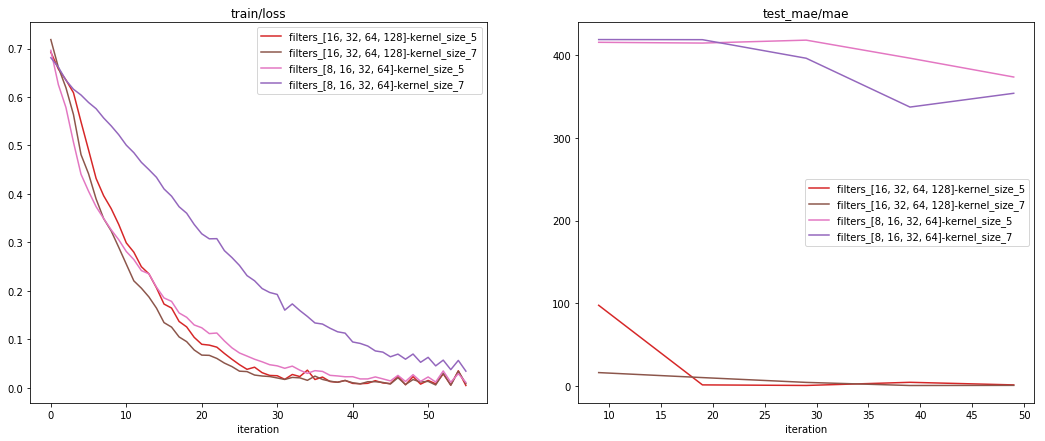

In [38]:
show_research(results, layout=['train/loss', 'test_mae/mae'], average_repetitions=True, color=list(mcolors.TABLEAU_COLORS.keys()))